# VQE exercise
Erel Dekel - 326064888 \
Dolev Shmaryahu - 326526258 \
Due to 03.07.2024

**Installations**

In [2]:
#%pip uninstall qiskit qiskit-aer qiskit-algorithms qiskit-ibm-runtime qiskit-ibm-provider
%pip install qiskit
%pip install numpy
%pip install qiskit-aer
%pip install qiskit-algorithms
%pip install matplotlib
%pip install qiskit-ibm-runtime
%pip install qiskit-ibm-provider


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


**Imports and code constants**


In [3]:
import qiskit
import numpy as np
import matplotlib.pyplot as plt
import qiskit.quantum_info as qi
import matplotlib.image as mpimg

from qiskit import transpile
from qiskit_algorithms import VQE
from qiskit_aer.noise import NoiseModel
from qiskit.primitives import Estimator
from qiskit.exceptions import QiskitError
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import circuit_drawer
from qiskit_algorithms.optimizers import COBYLA
from qiskit.quantum_info.operators import Operator
from qiskit_aer import Aer, QasmSimulator, AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeLimaV2
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_ibm_provider import IBMProvider
from qiskit_ibm_runtime import EstimatorV2
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Options
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

my_token = "d407187f614ca93bb6915bcd05eca072ee41ecdd390576d59743ec40c7d65bea240ab5098753d2608c5b80327f5c2fd1b2197a3a064eeac626781f2d5374cb98"
shots = 10**4

C:\Users\ereld\AppData\Local\Temp\ipykernel_16464\2723826471.py:20: DeprecationWarning: The package qiskit_ibm_provider is being deprecated. Please see https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime to get instructions on how to migrate to qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  from qiskit_ibm_provider import IBMProvider


**Constract H2 Hamiltonian**

In [4]:
g_0 = -0.4804
paulis = ["ZI", "IZ", "ZZ", "YY", "XX"]
coeffs = [0.3435, -0.4347, 0.5716, 0.0910, 0.0910]

H2 = g_0*Operator(qi.SparsePauliOp("II")) \
    +coeffs[0]*Operator(qi.SparsePauliOp(paulis[0])) \
    + coeffs[1]*Operator(qi.SparsePauliOp(paulis[1])) \
    + coeffs[2]*Operator(qi.SparsePauliOp(paulis[2])) \
    + coeffs[3]*Operator(qi.SparsePauliOp(paulis[3])) \
    + coeffs[4]*Operator(qi.SparsePauliOp(paulis[4]))
H2

Operator([[ 1.11022302e-16+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
            0.00000000e+00+0.j],
          [ 0.00000000e+00+0.j, -2.73800000e-01+0.j,  1.82000000e-01+0.j,
            0.00000000e+00+0.j],
          [ 0.00000000e+00+0.j,  1.82000000e-01+0.j, -1.83020000e+00+0.j,
            0.00000000e+00+0.j],
          [ 0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
            1.82400000e-01+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))


**Part 1: find the exact solution**

In [5]:
# Find min eigenvalue
eigen_values = np.linalg.eigvalsh(H2)
min_eigenvalue = min(eigen_values)

print("Exact result: " + str(min_eigenvalue))

nuclear_repulsion = 0.7055696146
hydrogen_atom_min_eigenvalue = min_eigenvalue + nuclear_repulsion

Exact result: -1.851199124123644


**Part 2: VQE using ideal simulation**

Important and useful functions

In [18]:
def ansatz_2local(reps = 1, show = False, num_qubits = 2):
    ansatz = TwoLocal(num_qubits=num_qubits, rotation_blocks='ry', entanglement_blocks='cx', reps=reps)

    if show:
        full_circuit = ansatz.decompose().decompose()
        circuit_drawer(full_circuit, output='mpl', style={'backgroundcolor': '#EEEEEE'}, filename='ansatz_circuit.png')
        img = mpimg.imread('ansatz_circuit.png')
        plt.figure(figsize=(6, 4))
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    return ansatz

def create_vqe_store_callback():
    counts = []
    values = []
    
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
        print(f"VQE on Aer qasm simulator (noisy): {mean:.7f}")
    
    return store_intermediate_result, counts, values

def run_VQE(ansatz, optimizer, estimator, operator, action=None):
    args = []
    if action:
        callback, *args = action()
        vqe = VQE(estimator=estimator, ansatz=ansatz, optimizer=optimizer, callback=callback)
    else:
        vqe = VQE(estimator=estimator, ansatz=ansatz, optimizer=optimizer)

    result = vqe.compute_minimum_eigenvalue(operator=SparsePauliOp.from_operator(operator))
    return result.eigenvalue.real, *args

Execution of part 2

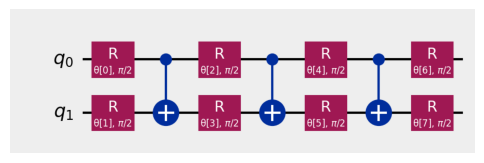

VQE on Aer qasm simulator (noisy): -1.7872288
VQE on Aer qasm simulator (noisy): -1.5044630
VQE on Aer qasm simulator (noisy): -1.4048359
VQE on Aer qasm simulator (noisy): -1.2736857
VQE on Aer qasm simulator (noisy): -1.6240918
VQE on Aer qasm simulator (noisy): -1.2433597
VQE on Aer qasm simulator (noisy): -1.2741418
VQE on Aer qasm simulator (noisy): -1.3178343
VQE on Aer qasm simulator (noisy): -1.5625869
VQE on Aer qasm simulator (noisy): -1.5515201
VQE on Aer qasm simulator (noisy): -1.7370300
VQE on Aer qasm simulator (noisy): -1.7795764
VQE on Aer qasm simulator (noisy): -1.8076925
VQE on Aer qasm simulator (noisy): -1.7514667
VQE on Aer qasm simulator (noisy): -1.8348339
VQE on Aer qasm simulator (noisy): -1.8046788
VQE on Aer qasm simulator (noisy): -1.8200445
VQE on Aer qasm simulator (noisy): -1.8173486
VQE on Aer qasm simulator (noisy): -1.8237151
VQE on Aer qasm simulator (noisy): -1.8409708
VQE on Aer qasm simulator (noisy): -1.8404941
VQE on Aer qasm simulator (noisy):

In [25]:
ansatz = ansatz_2local(reps = 3, show = True)
optimizer = COBYLA(maxiter=200)

seed = 170
estimator = AerEstimator(
    run_options={"seed": seed, "shots": shots},
    transpile_options={"seed_transpiler": seed},
)

vqe_ideal_ground_state_energy, counts, values = run_VQE(ansatz=ansatz, optimizer=optimizer, estimator=estimator, operator=H2, action=create_vqe_store_callback)

print(f"VQE Ground State Energy: {vqe_ideal_ground_state_energy}")
print(f"Error: {abs(vqe_ideal_ground_state_energy - min_eigenvalue)}")

Plotting interesting graph

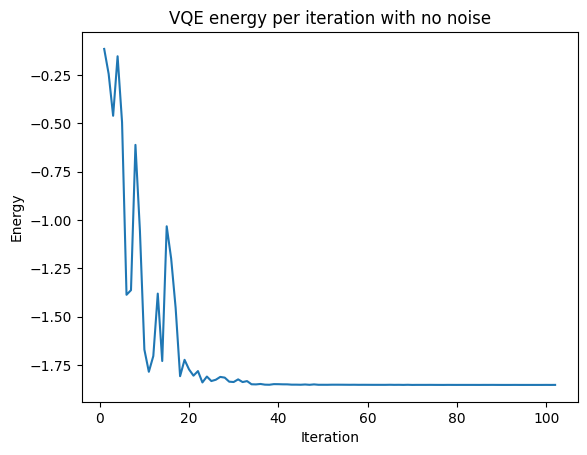

In [7]:
plt.plot(counts, values)
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("VQE energy per iteration with no noise")
plt.show()

**Part 3: VQE using noisy simulation**

Execution of part 3

In [16]:
ansatz = ansatz_2local()
coupling_map = [(0, 1), (1, 2), (2, 3), (3, 4)]

fake_lima = FakeLimaV2()
noise_model = NoiseModel.from_backend(fake_lima)
print(noise_model)

seed = 170
noisy_estimator = AerEstimator(
    backend_options={
        "method": "density_matrix",
        "coupling_map": coupling_map,
        "noise_model": noise_model,
    },
    run_options={"seed": seed, "shots": shots},
    transpile_options={"seed_transpiler": seed},
)

optimizer = COBYLA(maxiter=200)

vqe_noisy_ground_state_energy1l, counts, values = run_VQE(ansatz=ansatz, optimizer=optimizer, estimator=noisy_estimator, operator=H2, action=create_vqe_store_callback)
print(f"VQE Ground State Energy: {vqe_noisy_ground_state_energy1l}")
print(f"Error: {abs(vqe_noisy_ground_state_energy1l - min_eigenvalue)}")

NoiseModel:
  Basis gates: ['cx', 'delay', 'id', 'measure', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['id', 'cx', 'sx', 'reset', 'measure', 'x']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('cx', (0, 1)), ('cx', (1, 0)), ('cx', (1, 2)), ('cx', (1, 3)), ('cx', (2, 1)), ('cx', (3, 1)), ('cx', (3, 4)), ('cx', (4, 3)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,))]
VQE on Aer qasm simulator (noisy): -0.5775240
VQE on Aer qasm simulator (noisy): -0.7678926
VQE on Aer qasm simulator (noisy): -0.1328688
VQE on Aer qasm simulator (noisy): -0.5328278
VQE on Aer qasm simulator (noisy): -1.5118046
VQE on Aer qasm simulator (noisy): -1

In [26]:
ansatz = ansatz_2local(reps= 3)
coupling_map = [(0, 1), (1, 2), (2, 3), (3, 4)]

fake_lima = FakeLimaV2()
noise_model = NoiseModel.from_backend(fake_lima)
print(noise_model)

seed = 170
noisy_estimator = AerEstimator(
    backend_options={
        "method": "density_matrix",
        "coupling_map": coupling_map,
        "noise_model": noise_model,
    },
    run_options={"seed": seed, "shots": shots},
    transpile_options={"seed_transpiler": seed},
)

optimizer = COBYLA(maxiter=200)

vqe_noisy_ground_state_energy3l, counts, values = run_VQE(ansatz=ansatz, optimizer=optimizer, estimator=noisy_estimator, operator=H2, action=create_vqe_store_callback)
print(f"VQE Ground State Energy: {vqe_noisy_ground_state_energy3l}")
print(f"Error: {abs(vqe_noisy_ground_state_energy3l - min_eigenvalue)}")

NoiseModel:
  Basis gates: ['cx', 'delay', 'id', 'measure', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['id', 'cx', 'sx', 'reset', 'measure', 'x']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('cx', (0, 1)), ('cx', (1, 0)), ('cx', (1, 2)), ('cx', (1, 3)), ('cx', (2, 1)), ('cx', (3, 1)), ('cx', (3, 4)), ('cx', (4, 3)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,))]
VQE on Aer qasm simulator (noisy): -0.3352734
VQE on Aer qasm simulator (noisy): -0.1126701
VQE on Aer qasm simulator (noisy): -0.9662293
VQE on Aer qasm simulator (noisy): -1.1840372
VQE on Aer qasm simulator (noisy): -1.5688949
VQE on Aer qasm simulator (noisy): -1

Plotting interesting graph

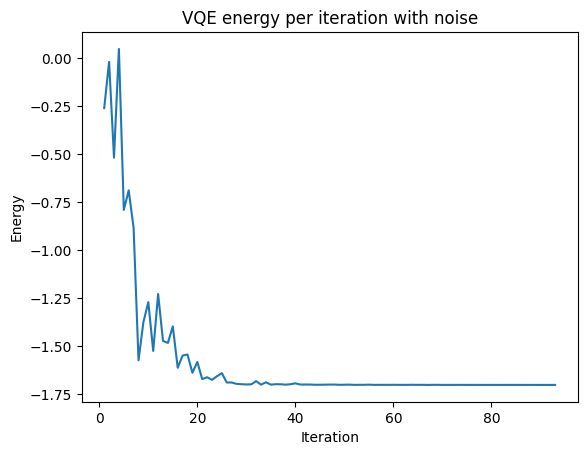

In [15]:
plt.plot(counts, values)
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("VQE energy per iteration with noise")
plt.show()

**Part 4: VQE using real hardware**

In [7]:
try:
    provider = IBMProvider(token=my_token)
    print("Successfully loaded IBM Quantum account.")
except:
    IBMProvider.save_account(token=my_token, instance="ibm-q/open/main", overwrite=True)
    provider = IBMProvider(token=my_token)
    print("Saved and loaded IBM Quantum account.")

service = QiskitRuntimeService(channel="ibm_quantum", token=my_token)

backend = service.least_busy(operational = True, simulator = False)
print(f"Using BackEnd {backend.name}")

Successfully loaded IBM Quantum account.
Using BackEnd ibm_kyoto


In [8]:
ansatz = ansatz_2local()
H2_op = SparsePauliOp.from_list(
    [
        ("II", -0.4804),
        ("ZI", coeffs[0]),
        ("IZ", coeffs[1]),
        ("ZZ", coeffs[2]),
        ("YY", coeffs[3]),
        ("XX", coeffs[4]),
    ]
)

pm = generate_preset_pass_manager(target=backend.target, optimization_level=1)
isa_psi = pm.run(ansatz)
isa_observables = H2_op.apply_layout(isa_psi.layout)
isa_psi.draw('mpl')
theta = [0, 1, 1, 2]

In [10]:
def run_vqe_hardware(use_mitigation=False, use_simulator=False):
    try:
        with Session(service=service, backend=backend) as session:
            options = {
                'resilience_level': 1 if use_mitigation else 0,
                'optimization_level': 1,
            }
            print(f"Resilience level set to: {options['resilience_level']}")

            estimator = EstimatorV2(session=session, options= options)

            job = estimator.run([(isa_psi, isa_observables, [theta])])

            result = job.result()[0]
            print(f"Job ID: {job.job_id()}")
            print(f"Job Status: {job.status()}")
            return result.data  # Return as a dictionary with 'evs' key
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        if 'job' in locals():
            print(f"Job ID: {job.job_id()}")
            print(f"Job Status: {job.status()}")
            print(f"Job Error Message: {job.error_message()}")
        return None

In [12]:
# Run VQE without error mitigation
print("Running VQE without error mitigation...")
energy_no_mitigation = run_vqe_hardware(use_mitigation=False)
print(f"Ground state energy without mitigation: {energy_no_mitigation.evs}")

Running VQE without error mitigation...
Resilience level set to: 0


C:\Users\ereld\AppData\Local\Temp\ipykernel_16464\1078111807.py:10: DeprecationWarning: The 'session' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  estimator = EstimatorV2(session=session, options= options)


Job ID: ct2cmb9kmkz00085zn10
Job Status: DONE
Ground state energy without mitigation: [-0.83024209]


In [11]:
# Run VQE with error mitigation
print("Running VQE with error mitigation...")
energy_with_mitigation = run_vqe_hardware(use_mitigation=True)
print(f"Ground state energy with mitigation: {energy_with_mitigation.evs}")

Running VQE with error mitigation...
Resilience level set to: 1


C:\Users\ereld\AppData\Local\Temp\ipykernel_16464\1078111807.py:10: DeprecationWarning: The 'session' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  estimator = EstimatorV2(session=session, options= options)


Job ID: ct2ckpymqj7g008zv7ng
Job Status: DONE
Ground state energy with mitigation: [-1.62224308]


In [13]:
# Calculate errors
error_no_mitigation = abs(energy_no_mitigation.evs[0] - min_eigenvalue)
error_with_mitigation = abs(energy_with_mitigation.evs[0] - min_eigenvalue)

print(f"Error without mitigation: {error_no_mitigation}")
print(f"Error with mitigation: {error_with_mitigation}")

Error without mitigation: 1.0209570342798941
Error with mitigation: 0.22895604207019438


**Part 5: Analazing result**

Fisrt lets check the errors in each part:
$$ Error^{H_{2}}_{\text{ideal simulator}} = 0.0014[Ha] \qquad Error^{H_{2}}_{\text{noisy simulator 1l}} = 0.1141[Ha] \qquad Error^{H_{2}}_{\text{noisy simulator 3l}} = 0.1285[Ha]$$
$$ Error^{H_{2}}_{\text{hardware without mitigation}} = 1.0209[Ha] \qquad Error^{H_{2}}_{\text{hardware with mitigation}} = 0.2289[Ha]$$

The chemical accuracy threshold is $1.6 [mHa]$.

Firstly, note that the ideal simulator achieves chemical accuracy. However, none of the other experiments managed to reach this threshold.

The best result we obtained, excluding the ideal simulator, was with the noisy simulator with one layer (1l). The error in this case is caused by the noise in the simulation. The reason for the larger error in the three-layer noisy simulation (3l) is that although a deeper ansatz is more expressive and can represent more complex states, it also involves more quantum gates, which increases the circuit's susceptibility to noise.

On real hardware, the results we obtained are far from chemical accuracy, primarily due to the noise and imperfections in current quantum devices. However, with error mitigation, we achieved much better results. This improvement is because error mitigation techniques use noise-reducing strategies such as zero-noise extrapolation, readout error mitigation, and more advanced error correction methods to reach better results.